## Import

In [1]:
# Import of basic packages
import numpy as np
import pandas as pd
import operator
from joblib import dump, load
import sys
import warnings

warnings.filterwarnings('ignore')

# Import of chart packages
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import altair as alt

# Import for normal distribution
import pylab
import scipy.stats as stats
import statsmodels.api as sm
from scipy.stats import shapiro

# Import of machine learning metric packages
from sklearn.metrics import make_scorer, f1_score, classification_report, confusion_matrix, mean_squared_error, r2_score, accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve, fbeta_score
from sklearn import metrics
from scipy.stats import randint, uniform, loguniform

# Import of preprossesor packages
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder, LabelBinarizer, PolynomialFeatures

# Import of machine learning packages
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier, RandomForestClassifier, RandomForestRegressor, VotingClassifier, StackingRegressor, StackingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

# Set random seed 
RSEED = 0

## Style

In [2]:
pd.set_option('display.max_columns', None)

## Load

In [3]:
# Load csv
df = pd.read_csv('data/train.csv')
df.head(3)

ID       DATOP     FLTID DEPSTN ARRSTN                  STD   
0  train_id_0  2016-01-03  TU 0712     CMN    TUN  2016-01-03 10:30:00  \
1  train_id_1  2016-01-13  TU 0757     MXP    TUN  2016-01-13 15:05:00   
2  train_id_2  2016-01-16  TU 0214     TUN    IST  2016-01-16 04:10:00   

                   STA STATUS         AC  target  
0  2016-01-03 12.55.00    ATA  TU 32AIMN   260.0  
1  2016-01-13 16.55.00    ATA  TU 31BIMO    20.0  
2  2016-01-16 06.45.00    ATA  TU 32AIMN     0.0

## Explore data analysis

In [4]:
# EDA info & describe
info = pd.concat([
df.dtypes.to_frame().T,
df.mean(numeric_only=True).to_frame().T,
df.std(numeric_only=True).to_frame().T,
df.min(numeric_only=True).to_frame().T,
df.quantile(0.25, numeric_only=True).to_frame().T,
df.quantile(0.5, numeric_only=True).to_frame().T, 
df.quantile(0.75, numeric_only=True).to_frame().T,
df.max(numeric_only=True).to_frame().T,], ignore_index=True).applymap(lambda x: round(x, 1) if isinstance(x, (int, float)) else x)

info.insert(0, 'statistic', ['dtype', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'])
info

statistic      ID   DATOP   FLTID  DEPSTN  ARRSTN     STD     STA  STATUS   
0     dtype  object  object  object  object  object  object  object  object  \
1      mean     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2       std     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3       min     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4       25%     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
5       50%     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
6       75%     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
7       max     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

       AC   target  
0  object  float64  
1     NaN     48.7  
2     NaN    117.1  
3     NaN      0.0  
4     NaN      0.0  
5     NaN     14.0  
6     NaN     43.0  
7     NaN   3451.0

In [5]:
# EDA duplicates
duplicates = df.duplicated().sum()
duplicate_percentage = round((duplicates / df.shape[0]) * 100, 1)
df[df.duplicated(keep=False)].head(10)

Empty DataFrame
Columns: [ID, DATOP, FLTID, DEPSTN, ARRSTN, STD, STA, STATUS, AC, target]
Index: []

In [6]:
# EDA NaNs
missing = pd.DataFrame(df.isnull().sum(), columns=['Amount'])
missing['Percentage'] = round((missing['Amount']/df.shape[0]) * 100, 1)
missing[missing['Amount'] != 0]

Empty DataFrame
Columns: [Amount, Percentage]
Index: []

In [7]:
# EDA shape
print('Number of rows and columns: ',df.shape)
print('-'*50)
pd.concat([df.head(3), df.tail(3)]).reset_index(drop=True)

Number of rows and columns:  (107833, 10)
--------------------------------------------------


ID       DATOP      FLTID DEPSTN ARRSTN                  STD   
0       train_id_0  2016-01-03   TU 0712     CMN    TUN  2016-01-03 10:30:00  \
1       train_id_1  2016-01-13   TU 0757     MXP    TUN  2016-01-13 15:05:00   
2       train_id_2  2016-01-16   TU 0214     TUN    IST  2016-01-16 04:10:00   
3  train_id_107830  2018-11-07  SGT 0000     TUN    TUN  2018-11-07 05:00:00   
4  train_id_107831  2018-01-23   UG 0010     TUN    DJE  2018-01-23 18:00:00   
5  train_id_107832  2018-11-13   UG 0002     TUN    DJE  2018-11-13 06:15:00   

                   STA STATUS         AC  target  
0  2016-01-03 12.55.00    ATA  TU 32AIMN   260.0  
1  2016-01-13 16.55.00    ATA  TU 31BIMO    20.0  
2  2016-01-16 06.45.00    ATA  TU 32AIMN     0.0  
3  2018-11-07 12.50.00    SCH  TU 736IOK     0.0  
4  2018-01-23 18.45.00    ATA  TU CR9ISA     0.0  
5  2018-11-13 07.05.00    SCH  TU CR9ISA     0.0

In [8]:
# EDA Uniques
unique_counts = pd.DataFrame(df.nunique(), columns=['Amount']).sort_values('Amount', ascending=False).T
unique_counts

ID    STA    STD  FLTID  DATOP  target  DEPSTN  ARRSTN  AC  STATUS
Amount  107833  85136  81697   1861   1011     968     132     128  68       5

In [9]:
df.head(10)

ID       DATOP     FLTID DEPSTN ARRSTN                  STD   
0  train_id_0  2016-01-03  TU 0712     CMN    TUN  2016-01-03 10:30:00  \
1  train_id_1  2016-01-13  TU 0757     MXP    TUN  2016-01-13 15:05:00   
2  train_id_2  2016-01-16  TU 0214     TUN    IST  2016-01-16 04:10:00   
3  train_id_3  2016-01-17  TU 0480     DJE    NTE  2016-01-17 14:10:00   
4  train_id_4  2016-01-17  TU 0338     TUN    ALG  2016-01-17 14:30:00   
5  train_id_5  2016-01-17  TU 0283     TLS    TUN  2016-01-17 16:20:00   
6  train_id_6  2016-01-18  TU 0514     TUN    BCN  2016-01-18 07:15:00   
7  train_id_7  2016-01-18  TU 0716     TUN    ORY  2016-01-18 07:35:00   
8  train_id_8  2016-01-18  TU 0752     TUN    FCO  2016-01-18 07:40:00   
9  train_id_9  2016-01-18  TU 0996     TUN    NCE  2016-01-18 07:45:00   

                   STA STATUS         AC  target  
0  2016-01-03 12.55.00    ATA  TU 32AIMN   260.0  
1  2016-01-13 16.55.00    ATA  TU 31BIMO    20.0  
2  2016-01-16 06.45.00    ATA  TU 32AIMN     0.0  
3  2016-01-17 17.00.00    ATA  TU 736IOK     0.0  
4  2016-01-17 15.50.00    ATA  TU 320IMU    22.0  
5  2016-01-17 18.15.00    ATA  TU 736IOP    53.0  
6  2016-01-18 09.00.00    ATA  TU 32AIMH    10.0  
7  2016-01-18 09.55.00    ATA  TU 32AIMI    15.0  
8  2016-01-18 09.00.00    ATA  TU 32AIMC    16.0  
9  2016-01-18 09.15.00    ATA  TU 31AIMK    21.0

In [10]:
# Get dataframe for delayed flights
df_delayed = df.copy()
df_delayed = df_delayed[df_delayed["target"] > 0]
df_delayed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 69665 entries, 0 to 107675
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      69665 non-null  object 
 1   DATOP   69665 non-null  object 
 2   FLTID   69665 non-null  object 
 3   DEPSTN  69665 non-null  object 
 4   ARRSTN  69665 non-null  object 
 5   STD     69665 non-null  object 
 6   STA     69665 non-null  object 
 7   STATUS  69665 non-null  object 
 8   AC      69665 non-null  object 
 9   target  69665 non-null  float64
dtypes: float64(1), object(9)
memory usage: 5.8+ MB


General statistics of target:
 count    107833.000000
mean         48.733013
std         117.135562
min           0.000000
25%           0.000000
50%          14.000000
75%          43.000000
max        3451.000000
Name: target, dtype: float64


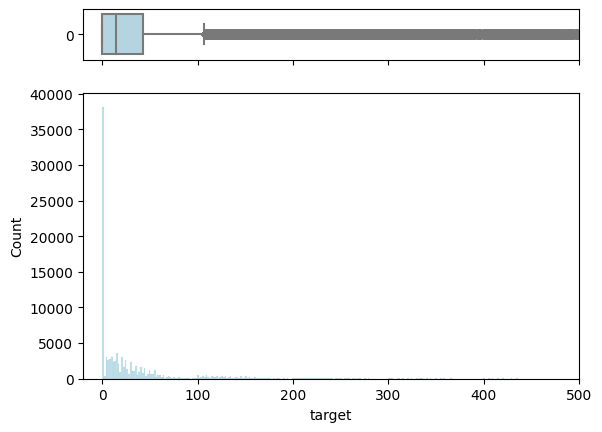

In [11]:
# Overview of target distribution
print("General statistics of target:\n", (df['target']).describe())

# Creating a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Assigning a graph to each ax
sns.boxplot(df["target"], orient="h", ax=ax_box, color='lightblue')
sns.histplot(data=df, x="target", ax=ax_hist, color='lightblue')

# Remove x axis name for the boxplot
ax_box.set(xlabel='')
ax_box.set_xlim([-20, 500])
plt.show()

General statistics of target (of delayed flights):
 count    69665.000000
mean        75.432814
std        138.650946
min          1.000000
25%         15.000000
50%         30.000000
75%         74.000000
max       3451.000000
Name: target, dtype: float64


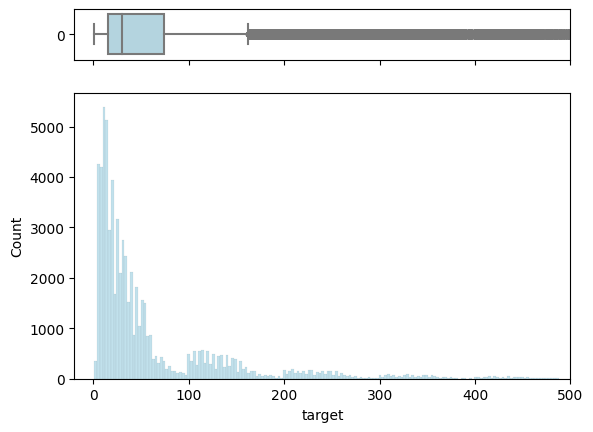

In [12]:
# Overview of target distribution (of delayed flights)
print("General statistics of target (of delayed flights):\n", (df_delayed['target']).describe())

# Creating a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Assigning a graph to each ax
sns.boxplot(df_delayed["target"], orient="h", ax=ax_box, color='lightblue')
sns.histplot(data=df_delayed, x="target", ax=ax_hist, color='lightblue')

# Remove x axis name for the boxplot
ax_box.set(xlabel='')
ax_box.set_xlim([-20, 500])
plt.show()

In [13]:
stat, p = shapiro(df_delayed['target'])

# Interpretation of p-value
alpha = 0.05
if p > alpha:
    print('The data of column "target" looks normally distributed (p > 0.05, fail to reject H0).')
else:
    print('The data of column "target" does not look normally distributed (p < 0.05, reject H0).')

The data of column "target" does not look normally distributed (p < 0.05, reject H0).


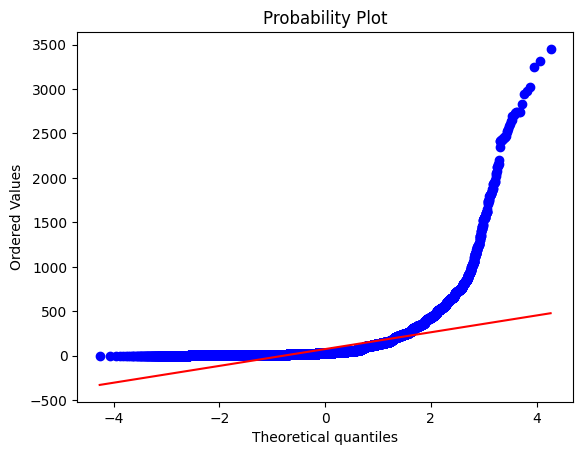

In [14]:
# Grafic methode: Q-Q-Plot
stats.probplot(df_delayed['target'], dist="norm", plot=pylab)
pylab.show()

Check influence of departure and arrival airport route

In [15]:
df['flight_route'] = df["DEPSTN"] + df["ARRSTN"]

In [16]:
# Get 5 most frequent flight routes
df['flight_route'].value_counts(sort=True).head(5)

flight_route
ORYTUN    4579
TUNORY    4564
TUNTUN    4320
DJETUN    3645
TUNDJE    3521
Name: count, dtype: int64

In [17]:
df[df["flight_route"]=="TUNTUN"].head(5)

ID       DATOP     FLTID DEPSTN ARRSTN                  STD   
418    train_id_418  2016-07-09  TU 0744     TUN    TUN  2016-07-09 07:05:00  \
461    train_id_461  2016-08-15  TU 0526     TUN    TUN  2016-08-15 06:25:00   
1294  train_id_1294  2016-06-30  TU 9975     TUN    TUN  2016-06-30 10:00:00   
2237  train_id_2237  2016-03-10  TU 9950     TUN    TUN  2016-03-10 05:00:00   
2491  train_id_2491  2016-06-11  TU 0716     TUN    TUN  2016-06-11 06:50:00   

                      STA STATUS         AC  target flight_route  
418   2016-07-09 09.40.00    RTR  TU 320IMR     3.0       TUNTUN  
461   2016-08-15 09.10.00    RTR  TU 736IOL    17.0       TUNTUN  
1294  2016-06-30 11.00.00    ATA  TU 736IOP   135.0       TUNTUN  
2237  2016-03-10 06.00.00    ATA  TU 32AIMH    12.0       TUNTUN  
2491  2016-06-11 09.10.00    RTR  TU 320IMU     0.0       TUNTUN

In [18]:
# Get all entries, where dep and arr airport are the same
df[df["DEPSTN"]==df["ARRSTN"]].shape

(5523, 11)

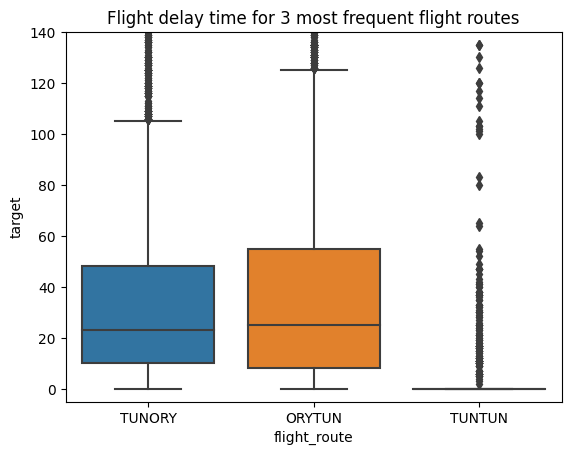

In [19]:
# Start with a basic boxplot
sns.boxplot(x="flight_route", y="target", data=df[(df['flight_route']=="TUNORY") | (df['flight_route']=="ORYTUN") | (df['flight_route']=="TUNTUN")])

# add title
plt.title("Flight delay time for 3 most frequent flight routes")
plt.ylim(-5, 140)

# show the graph
plt.show()

In [20]:
# Get top 5 flight routes with most delay time
top_categories = df.groupby('flight_route')['target'].sum().nlargest(5)

print(top_categories)

flight_route
ORYTUN    243674.0
TUNORY    209819.0
ISTTUN    137164.0
MRSTUN    132420.0
TUNIST    128491.0
Name: target, dtype: float64


In [21]:
print("ORYTUN contribution to total delay time in %: ", round((487348/df["target"].sum())*100, 2))

ORYTUN contribution to total delay time in %:  9.27


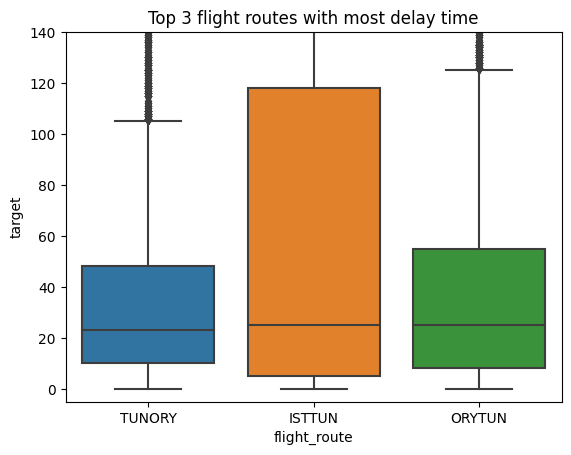

In [22]:
# Start with a basic boxplot
sns.boxplot(x="flight_route", y="target", data=df[(df['flight_route']=="ORYTUN") | (df['flight_route']=="TUNORY") | (df['flight_route']=="ISTTUN")])

# add title
plt.title("Top 3 flight routes with most delay time")
plt.ylim(-5, 140)

# show the graph
plt.show()

In [23]:
df = df.drop("flight_route", axis=1)

## Data cleaning

In [24]:
# Clean column names
df.columns = df.columns.str.replace(' ','_')
df.columns = df.columns.str.lower()

Feature 'ac' holds information about the model of the airplane. Extracting and converting the information.

In [25]:
df['airplane_model'] = df['ac'].str[3:6]
df.head()

id       datop     fltid depstn arrstn                  std   
0  train_id_0  2016-01-03  TU 0712     CMN    TUN  2016-01-03 10:30:00  \
1  train_id_1  2016-01-13  TU 0757     MXP    TUN  2016-01-13 15:05:00   
2  train_id_2  2016-01-16  TU 0214     TUN    IST  2016-01-16 04:10:00   
3  train_id_3  2016-01-17  TU 0480     DJE    NTE  2016-01-17 14:10:00   
4  train_id_4  2016-01-17  TU 0338     TUN    ALG  2016-01-17 14:30:00   

                   sta status         ac  target airplane_model  
0  2016-01-03 12.55.00    ATA  TU 32AIMN   260.0            32A  
1  2016-01-13 16.55.00    ATA  TU 31BIMO    20.0            31B  
2  2016-01-16 06.45.00    ATA  TU 32AIMN     0.0            32A  
3  2016-01-17 17.00.00    ATA  TU 736IOK     0.0            736  
4  2016-01-17 15.50.00    ATA  TU 320IMU    22.0            320

In [26]:
# EDA Uniques
unique_counts = pd.DataFrame(df.nunique(), columns=['Amount']).sort_values('Amount', ascending=False).T
unique_counts

id    sta    std  fltid  datop  target  depstn  arrstn  ac   
Amount  107833  85136  81697   1861   1011     968     132     128  68  \

        airplane_model  status  
Amount              16       5

In [27]:
set(df['airplane_model'])

{'319',
 '31A',
 '31B',
 '320',
 '321',
 '32A',
 '332',
 '343',
 '345',
 '733',
 '734',
 '736',
 '738',
 'AT7',
 'CR9',
 'M87'}

In [28]:
replacement_dict = {
    '31A': 'Airbus',
    '31B': 'Airbus',
    '320': 'Airbus',
    '321': 'Airbus',
    '32A': 'Airbus',
    '332': 'Airbus',
    '343': 'Airbus',
    '345': 'Airbus',
    '733': 'Boeing',
    '734': 'Boeing',
    '736': 'Boeing',
    'AT7': 'ATR',
    'CR9': 'Bombardier'
}

df['producer'] = df['airplane_model']

# Replace values in the 'purpose' column
df['producer'] = df['producer'].replace(replacement_dict)


In [29]:
df.head()

id       datop     fltid depstn arrstn                  std   
0  train_id_0  2016-01-03  TU 0712     CMN    TUN  2016-01-03 10:30:00  \
1  train_id_1  2016-01-13  TU 0757     MXP    TUN  2016-01-13 15:05:00   
2  train_id_2  2016-01-16  TU 0214     TUN    IST  2016-01-16 04:10:00   
3  train_id_3  2016-01-17  TU 0480     DJE    NTE  2016-01-17 14:10:00   
4  train_id_4  2016-01-17  TU 0338     TUN    ALG  2016-01-17 14:30:00   

                   sta status         ac  target airplane_model producer  
0  2016-01-03 12.55.00    ATA  TU 32AIMN   260.0            32A   Airbus  
1  2016-01-13 16.55.00    ATA  TU 31BIMO    20.0            31B   Airbus  
2  2016-01-16 06.45.00    ATA  TU 32AIMN     0.0            32A   Airbus  
3  2016-01-17 17.00.00    ATA  TU 736IOK     0.0            736   Boeing  
4  2016-01-17 15.50.00    ATA  TU 320IMU    22.0            320   Airbus

In [30]:
df['airline_1'] = df['fltid'].str[0:2]
df.head()

id       datop     fltid depstn arrstn                  std   
0  train_id_0  2016-01-03  TU 0712     CMN    TUN  2016-01-03 10:30:00  \
1  train_id_1  2016-01-13  TU 0757     MXP    TUN  2016-01-13 15:05:00   
2  train_id_2  2016-01-16  TU 0214     TUN    IST  2016-01-16 04:10:00   
3  train_id_3  2016-01-17  TU 0480     DJE    NTE  2016-01-17 14:10:00   
4  train_id_4  2016-01-17  TU 0338     TUN    ALG  2016-01-17 14:30:00   

                   sta status         ac  target airplane_model producer   
0  2016-01-03 12.55.00    ATA  TU 32AIMN   260.0            32A   Airbus  \
1  2016-01-13 16.55.00    ATA  TU 31BIMO    20.0            31B   Airbus   
2  2016-01-16 06.45.00    ATA  TU 32AIMN     0.0            32A   Airbus   
3  2016-01-17 17.00.00    ATA  TU 736IOK     0.0            736   Boeing   
4  2016-01-17 15.50.00    ATA  TU 320IMU    22.0            320   Airbus   

  airline_1  
0        TU  
1        TU  
2        TU  
3        TU  
4        TU

In [31]:
set(df['airline_1'])

{'12',
 '20',
 '6Y',
 'A ',
 'AO',
 'AT',
 'AU',
 'C ',
 'D4',
 'DA',
 'GJ',
 'IN',
 'PR',
 'SG',
 'TU',
 'UG',
 'UH',
 'WK',
 'X9'}

In [32]:
df['airline_2'] = df['ac'].str[0:2]
df.head()

id       datop     fltid depstn arrstn                  std   
0  train_id_0  2016-01-03  TU 0712     CMN    TUN  2016-01-03 10:30:00  \
1  train_id_1  2016-01-13  TU 0757     MXP    TUN  2016-01-13 15:05:00   
2  train_id_2  2016-01-16  TU 0214     TUN    IST  2016-01-16 04:10:00   
3  train_id_3  2016-01-17  TU 0480     DJE    NTE  2016-01-17 14:10:00   
4  train_id_4  2016-01-17  TU 0338     TUN    ALG  2016-01-17 14:30:00   

                   sta status         ac  target airplane_model producer   
0  2016-01-03 12.55.00    ATA  TU 32AIMN   260.0            32A   Airbus  \
1  2016-01-13 16.55.00    ATA  TU 31BIMO    20.0            31B   Airbus   
2  2016-01-16 06.45.00    ATA  TU 32AIMN     0.0            32A   Airbus   
3  2016-01-17 17.00.00    ATA  TU 736IOK     0.0            736   Boeing   
4  2016-01-17 15.50.00    ATA  TU 320IMU    22.0            320   Airbus   

  airline_1 airline_2  
0        TU        TU  
1        TU        TU  
2        TU        TU  
3        TU        TU  
4        TU        TU

In [33]:
set(df['airline_2'])

{'5K',
 '5M',
 '6P',
 'BJ',
 'D4',
 'GJ',
 'GW',
 'OL',
 'PS',
 'QS',
 'TU',
 'UG',
 'UJ',
 'X9'}

In [34]:
df.head()

id       datop     fltid depstn arrstn                  std   
0  train_id_0  2016-01-03  TU 0712     CMN    TUN  2016-01-03 10:30:00  \
1  train_id_1  2016-01-13  TU 0757     MXP    TUN  2016-01-13 15:05:00   
2  train_id_2  2016-01-16  TU 0214     TUN    IST  2016-01-16 04:10:00   
3  train_id_3  2016-01-17  TU 0480     DJE    NTE  2016-01-17 14:10:00   
4  train_id_4  2016-01-17  TU 0338     TUN    ALG  2016-01-17 14:30:00   

                   sta status         ac  target airplane_model producer   
0  2016-01-03 12.55.00    ATA  TU 32AIMN   260.0            32A   Airbus  \
1  2016-01-13 16.55.00    ATA  TU 31BIMO    20.0            31B   Airbus   
2  2016-01-16 06.45.00    ATA  TU 32AIMN     0.0            32A   Airbus   
3  2016-01-17 17.00.00    ATA  TU 736IOK     0.0            736   Boeing   
4  2016-01-17 15.50.00    ATA  TU 320IMU    22.0            320   Airbus   

  airline_1 airline_2  
0        TU        TU  
1        TU        TU  
2        TU        TU  
3        TU        TU  
4        TU        TU

Load airpots data set and clean. 

Merge data sets based on airport short handle. 

In [35]:
# Add columns with weekdays, yyyy, mm, dd, hh:mm:ss

y = '_year'
m = '_month'
wd = '_wd'
M = '_min'

### std ###

date = 'std'

idx = df.columns.get_loc(date)

df[date] = pd.to_datetime(df[date], format='%Y-%m-%d %H:%M:%S')
df.insert(loc=idx+1, column=date+y, value=df[date].dt.strftime('%Y')) # year yyyy
df.insert(loc=idx+2, column=date+m, value=df[date].dt.strftime('%#m')) # month m
df.insert(loc=idx+3, column=date+wd, value=df[date].dt.strftime('%w')) # weekday wd
h = df[date].dt.strftime('%#H').astype(int) # hours
minutes = df[date].dt.strftime('%#M').astype(int) # minutes
# calcualte time in just minutes
t = 60*h + minutes
df.insert(loc=idx+4, column=date+M, value=t) # minutes

### sta ###

date = 'sta'

idx = df.columns.get_loc(date)

df[date] = pd.to_datetime(df[date], format='%Y-%m-%d %H.%M.%S')
df.insert(loc=idx+1, column=date+y, value=df[date].dt.strftime('%Y')) # year yyyy
df.insert(loc=idx+2, column=date+m, value=df[date].dt.strftime('%#m')) # month m
df.insert(loc=idx+3, column=date+wd, value=df[date].dt.strftime('%w')) # weekday wd
h = df[date].dt.strftime('%#H').astype(int) # hours
minutes = df[date].dt.strftime('%#M').astype(int)
# calcualte time in just minutes
t = 60*h + minutes
df.insert(loc=idx+4, column=date+M, value=t) # minutes

### datop ###

date = 'datop'

idx = df.columns.get_loc(date)

df[date] = pd.to_datetime(df[date], format='%Y-%m-%d')
df.insert(loc=idx+1, column=date+y, value=df[date].dt.strftime('%Y')) # year yyyy
df.insert(loc=idx+2, column=date+m, value=df[date].dt.strftime('%#m')) # month m
df.insert(loc=idx+3, column=date+wd, value=df[date].dt.strftime('%w')) # weekday wd

# convert new columns as integers
list = ['std_year', 'std_month', 'std_wd', 'sta_year', 'sta_month', 'sta_wd', 'datop_year', 'datop_month', 'datop_wd', 'target']

for date in list:
    df[date] = df[date].astype(int)

# change weekday numbers to EU where day 1 = Monday
list = ['std_wd', 'sta_wd', 'datop_wd']

for date in list:
    df[date][df[date] == 0] = 7 # Sunday

Geo-encoding of airports

In [36]:
# Load csv
df_airports = pd.read_csv('data/airports.csv')
df_airports.columns = ['id', 'name', 'city', 'country', 'short', 'rubbish_6', 'latitude', 'longitude', 'rubbish_1', 'rubbish_2', 'rubbish_3', 'rubbish_4', 'type', 'rubbish_5']
df_airports = df_airports.drop(['id', 'name', 'rubbish_1', 'rubbish_2', 'rubbish_3', 'rubbish_4', 'rubbish_5', 'rubbish_6', 'type'], axis=1)
df_airports = df_airports.dropna(subset=['short'])
df_airports.head(3)


city  country short   latitude   longitude
0  Pitt Meadows   Canada    \N  49.216099 -122.709999
1         Blida  Algeria    \N  36.503601    2.814170
2     Bou Saada  Algeria    \N  35.332500    4.206390

In [37]:
df = df.merge(df_airports, left_on='depstn', right_on='short', how='left', suffixes=('', '_dep'))

# Merge based on arrival station
df = df.merge(df_airports, left_on='arrstn', right_on='short', how='left', suffixes=('', '_arr'))

# Rename columns for clarity
df = df.rename(columns={
    'city': 'city_dep',
    'country': 'country_dep',
    'latitude': 'latitude_dep',
    'longitude': 'longitude_dep'
})

df.head(3)


id      datop  datop_year  datop_month  datop_wd     fltid depstn   
0  train_id_0 2016-01-03        2016            1         7  TU 0712     CMN  \
1  train_id_0 2016-01-03        2016            1         7  TU 0712     CMN   
2  train_id_1 2016-01-13        2016            1         3  TU 0757     MXP   

  arrstn                 std  std_year  std_month  std_wd  std_min   
0    TUN 2016-01-03 10:30:00      2016          1       7      630  \
1    TUN 2016-01-03 10:30:00      2016          1       7      630   
2    TUN 2016-01-13 15:05:00      2016          1       3      905   

                  sta  sta_year  sta_month  sta_wd  sta_min status         ac   
0 2016-01-03 12:55:00      2016          1       7      775    ATA  TU 32AIMN  \
1 2016-01-03 12:55:00      2016          1       7      775    ATA  TU 32AIMN   
2 2016-01-13 16:55:00      2016          1       3     1015    ATA  TU 31BIMO   

   target airplane_model producer airline_1 airline_2    city_dep country_dep   
0     260            32A   Airbus        TU        TU  Casablanca     Morocco  \
1     260            32A   Airbus        TU        TU  Casablanca     Morocco   
2      20            31B   Airbus        TU        TU      Milano       Italy   

  short  latitude_dep  longitude_dep city_arr country_arr short_arr   
0   CMN       33.3675       -7.58997    Tunis     Tunisia       TUN  \
1   CMN       33.3675       -7.58997    Tunis    Tunesia        TUN   
2   MXP       45.6306        8.72811    Tunis     Tunisia       TUN   

   latitude_arr  longitude_arr  
0     36.851002      10.227200  
1     36.847685      10.217603  
2     36.851002      10.227200

In [38]:
df = df.drop_duplicates(subset='id', keep='first')
df.shape

(107833, 35)

In [39]:
(df[(df["datop_year"]==df["std_year"])&(df["datop_month"]==df["std_month"])&(df["datop_wd"]==df["std_wd"])]).shape

(107833, 35)

In [40]:
# EDA info & describe
info = pd.concat([
df.dtypes.to_frame().T,
df.mean(numeric_only=True).to_frame().T,
df.std(numeric_only=True).to_frame().T,
df.min(numeric_only=True).to_frame().T,
df.quantile(0.25, numeric_only=True).to_frame().T,
df.quantile(0.5, numeric_only=True).to_frame().T, 
df.quantile(0.75, numeric_only=True).to_frame().T,
df.max(numeric_only=True).to_frame().T,], ignore_index=True).applymap(lambda x: round(x, 1) if isinstance(x, (int, float)) else x)

info.insert(0, 'statistic', ['dtype', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'])
info

statistic      id           datop datop_year datop_month datop_wd   fltid   
0     dtype  object  datetime64[ns]      int32       int32    int32  object  \
1      mean     NaN             NaN     2017.0         6.7      4.1     NaN   
2       std     NaN             NaN        0.8         3.3      2.0     NaN   
3       min     NaN             NaN     2016.0         1.0      1.0     NaN   
4       25%     NaN             NaN     2016.0         4.0      2.0     NaN   
5       50%     NaN             NaN     2017.0         7.0      4.0     NaN   
6       75%     NaN             NaN     2018.0         9.0      6.0     NaN   
7       max     NaN             NaN     2018.0        12.0      7.0     NaN   

   depstn  arrstn             std std_year std_month std_wd std_min   
0  object  object  datetime64[ns]    int32     int32  int32   int32  \
1     NaN     NaN             NaN   2017.0       6.7    4.1   751.6   
2     NaN     NaN             NaN      0.8       3.3    2.0   309.0   
3     NaN     NaN             NaN   2016.0       1.0    1.0     0.0   
4     NaN     NaN             NaN   2016.0       4.0    2.0   500.0   
5     NaN     NaN             NaN   2017.0       7.0    4.0   755.0   
6     NaN     NaN             NaN   2018.0       9.0    6.0   980.0   
7     NaN     NaN             NaN   2018.0      12.0    7.0  1439.0   

              sta sta_year sta_month sta_wd sta_min  status      ac  target   
0  datetime64[ns]    int32     int32  int32   int32  object  object   int32  \
1             NaN   2017.0       6.7    4.1   811.3     NaN     NaN    48.7   
2             NaN      0.8       3.3    2.0   323.1     NaN     NaN   117.1   
3             NaN   2016.0       1.0    1.0     0.0     NaN     NaN     0.0   
4             NaN   2016.0       4.0    2.0   585.0     NaN     NaN     0.0   
5             NaN   2017.0       7.0    4.0   810.0     NaN     NaN    14.0   
6             NaN   2018.0       9.0    6.0  1055.0     NaN     NaN    43.0   
7             NaN   2019.0      12.0    7.0  1439.0     NaN     NaN  3451.0   

  airplane_model producer airline_1 airline_2 city_dep country_dep   short   
0         object   object    object    object   object      object  object  \
1            NaN      NaN       NaN       NaN      NaN         NaN     NaN   
2            NaN      NaN       NaN       NaN      NaN         NaN     NaN   
3            NaN      NaN       NaN       NaN      NaN         NaN     NaN   
4            NaN      NaN       NaN       NaN      NaN         NaN     NaN   
5            NaN      NaN       NaN       NaN      NaN         NaN     NaN   
6            NaN      NaN       NaN       NaN      NaN         NaN     NaN   
7            NaN      NaN       NaN       NaN      NaN         NaN     NaN   

  latitude_dep longitude_dep city_arr country_arr short_arr latitude_arr   
0      float64       float64   object      object    object      float64  \
1         38.5           8.8      NaN         NaN       NaN         38.5   
2          7.7           8.4      NaN         NaN       NaN          7.7   
3        -11.6         -73.7      NaN         NaN       NaN        -11.6   
4         36.1           6.1      NaN         NaN       NaN         36.1   
5         36.9          10.2      NaN         NaN       NaN         36.9   
6         43.7          10.7      NaN         NaN       NaN         43.7   
7         64.0          51.6      NaN         NaN       NaN         59.8   

  longitude_arr  
0       float64  
1           8.8  
2           8.4  
3         -73.7  
4           6.1  
5          10.2  
6          10.7  
7          51.6

In [41]:
df.head(3)

id      datop  datop_year  datop_month  datop_wd     fltid depstn   
0  train_id_0 2016-01-03        2016            1         7  TU 0712     CMN  \
2  train_id_1 2016-01-13        2016            1         3  TU 0757     MXP   
4  train_id_2 2016-01-16        2016            1         6  TU 0214     TUN   

  arrstn                 std  std_year  std_month  std_wd  std_min   
0    TUN 2016-01-03 10:30:00      2016          1       7      630  \
2    TUN 2016-01-13 15:05:00      2016          1       3      905   
4    IST 2016-01-16 04:10:00      2016          1       6      250   

                  sta  sta_year  sta_month  sta_wd  sta_min status         ac   
0 2016-01-03 12:55:00      2016          1       7      775    ATA  TU 32AIMN  \
2 2016-01-13 16:55:00      2016          1       3     1015    ATA  TU 31BIMO   
4 2016-01-16 06:45:00      2016          1       6      405    ATA  TU 32AIMN   

   target airplane_model producer airline_1 airline_2    city_dep country_dep   
0     260            32A   Airbus        TU        TU  Casablanca     Morocco  \
2      20            31B   Airbus        TU        TU      Milano       Italy   
4       0            32A   Airbus        TU        TU       Tunis     Tunisia   

  short  latitude_dep  longitude_dep  city_arr country_arr short_arr   
0   CMN     33.367500       -7.58997     Tunis     Tunisia       TUN  \
2   MXP     45.630600        8.72811     Tunis     Tunisia       TUN   
4   TUN     36.851002       10.22720  Istanbul      Turkey       IST   

   latitude_arr  longitude_arr  
0     36.851002        10.2272  
2     36.851002        10.2272  
4     40.976898        28.8146

In [42]:
# Your existing code to create the scatter plot
fig = px.scatter_mapbox(df, lat="latitude_arr", lon="longitude_arr", 
                        color_discrete_sequence=["teal"], zoom=3)

# Custom mapbox style with opacity
mapbox_style = {
    "version": 8,
    "sources": {
        "osm": {
            "type": "raster",
            "tiles": ["https://a.tile.openstreetmap.org/{z}/{x}/{y}.png"],
            "tileSize": 256,
            "attribution": "&copy; OpenStreetMap Contributors",
            "maxzoom": 19
        }
    },
    "layers": [{
        "id": "osm",
        "type": "raster",
        "source": "osm",
        "paint": {"raster-opacity": 0.6}  # Set the opacity here
    }]
}

# Update layout with custom mapbox style
fig.update_layout(mapbox_style=mapbox_style)

# Your existing layout updates
fig.update_layout(width=1200, height=800)
fig.update_layout(title="Distribution of airports", title_x=0.5)

fig.show()

In [43]:
df.to_csv('data/data.csv', index=False)

## Feature engineering

In [44]:
df = df.drop(['datop_year', 'datop_month', 'datop_wd', 'datop', 'fltid', 'std', 'sta', 'ac', 'short', 'short_arr', 'city_dep', 'country_dep', 'city_arr', 'country_arr', 'airline_2', 'producer'], axis=1)
df.head(3)

id depstn arrstn  std_year  std_month  std_wd  std_min  sta_year   
0  train_id_0    CMN    TUN      2016          1       7      630      2016  \
2  train_id_1    MXP    TUN      2016          1       3      905      2016   
4  train_id_2    TUN    IST      2016          1       6      250      2016   

   sta_month  sta_wd  sta_min status  target airplane_model airline_1   
0          1       7      775    ATA     260            32A        TU  \
2          1       3     1015    ATA      20            31B        TU   
4          1       6      405    ATA       0            32A        TU   

   latitude_dep  longitude_dep  latitude_arr  longitude_arr  
0     33.367500       -7.58997     36.851002        10.2272  
2     45.630600        8.72811     36.851002        10.2272  
4     36.851002       10.22720     40.976898        28.8146

In [45]:
# List of columns to encode
columns_to_encode = ['depstn', 'status', 'arrstn', 'airline_1', 'airplane_model'] # reduced by aggressive feature drop

# Create a copy of the original dataframe
df_encoded = df.copy()

# Encode each column separately
for column in columns_to_encode:
    lb = LabelBinarizer()
    encoded = lb.fit_transform(df[column])
    
    # If binary classification, create a single column
    if len(lb.classes_) == 2:
        df_encoded[f'{column}_encoded'] = encoded
    else:
        # For multiclass, create multiple columns
        encoded_df = pd.DataFrame(encoded, columns=[f'{column}_{cls}' for cls in lb.classes_], index=df.index)
        df_encoded = pd.concat([df_encoded, encoded_df], axis=1)

df_encoded = df_encoded.drop(column, axis=1)

# Now, combine the non-encoded columns from df with the encoded columns from df_encoded
df = pd.concat([df, df_encoded], axis=1)


In [46]:
df = df.drop(['depstn', 'arrstn', 'status', 'airline_1', 'airplane_model'], axis=1) # reduced by aggressive feature drop
duplicate_columns = df.columns[df.columns.duplicated()]
df = df.loc[:, ~df.columns.duplicated()]

##### Target engineering

In [47]:
# Convert target into certain category intervals

def target_interval(row):
    if row['target'] == 0:
        return 1
    elif 0 < row['target'] <= 30:
        return 2
    elif 30 < row['target'] <= 60:
        return 3
    elif 60 < row['target'] <= 120:
        return 4
    elif 120 < row['target'] <= 240:
        return 5   
    else:
        return 6  
    
df['target_cat'] = df.apply(target_interval, axis=1)

<Axes: xlabel='target_cat', ylabel='Count'>

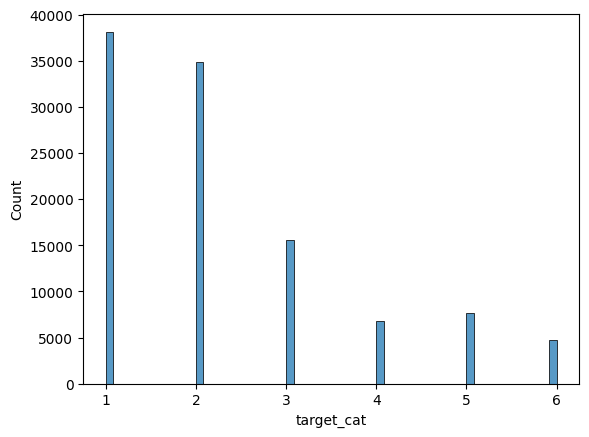

In [48]:
sns.histplot(data=df['target_cat'])

In [49]:
df.head(3)

id  std_year  std_month  std_wd  std_min  sta_year  sta_month   
0  train_id_0      2016          1       7      630      2016          1  \
2  train_id_1      2016          1       3      905      2016          1   
4  train_id_2      2016          1       6      250      2016          1   

   sta_wd  sta_min  target  latitude_dep  longitude_dep  latitude_arr   
0       7      775     260     33.367500       -7.58997     36.851002  \
2       3     1015      20     45.630600        8.72811     36.851002   
4       6      405       0     36.851002       10.22720     40.976898   

   longitude_arr  depstn_AAE  depstn_AAL  depstn_ABJ  depstn_ADB  depstn_AHU   
0        10.2272           0           0           0           0           0  \
2        10.2272           0           0           0           0           0   
4        28.8146           0           0           0           0           0   

   depstn_ALG  depstn_AMM  depstn_AMS  depstn_ARN  depstn_ATH  depstn_AYT   
0           0           0           0           0           0           0  \
2           0           0           0           0           0           0   
4           0           0           0           0           0           0   

   depstn_BCN  depstn_BDS  depstn_BEG  depstn_BEY  depstn_BJA  depstn_BKO   
0           0           0           0           0           0           0  \
2           0           0           0           0           0           0   
4           0           0           0           0           0           0   

   depstn_BLL  depstn_BLQ  depstn_BOD  depstn_BRI  depstn_BRQ  depstn_BRU   
0           0           0           0           0           0           0  \
2           0           0           0           0           0           0   
4           0           0           0           0           0           0   

   depstn_BTS  depstn_BUD  depstn_BYJ  depstn_CAG  depstn_CAI  depstn_CDG   
0           0           0           0           0           0           0  \
2           0           0           0           0           0           0   
4           0           0           0           0           0           0   

   depstn_CGN  depstn_CKY  depstn_CMN  depstn_COO  depstn_CPH  depstn_CRL   
0           0           0           1           0           0           0  \
2           0           0           0           0           0           0   
4           0           0           0           0           0           0   

   depstn_CTA  depstn_CZL  depstn_DJE  depstn_DKR  depstn_DOH  depstn_DSS   
0           0           0           0           0           0           0  \
2           0           0           0           0           0           0   
4           0           0           0           0           0           0   

   depstn_DUS  depstn_EBL  depstn_EBM  depstn_ESB  depstn_FBM  depstn_FCO   
0           0           0           0           0           0           0  \
2           0           0           0           0           0           0   
4           0           0           0           0           0           0   

   depstn_FIH  depstn_FRA  depstn_GAE  depstn_GAF  depstn_GHA  depstn_GNB   
0           0           0           0           0           0           0  \
2           0           0           0           0           0           0   
4           0           0           0           0           0           0   

   depstn_GVA  depstn_HAJ  depstn_HAM  depstn_HBE  depstn_IEV  depstn_IST   
0           0           0           0           0           0           0  \
2           0           0           0           0           0           0   
4           0           0           0           0           0           0   

   depstn_JED  depstn_JIB  depstn_KBP  depstn_KEF  depstn_KGL  depstn_KRR   
0           0           0           0           0           0           0  \
2           0           0           0           0           0           0   
4           0           0           0           0           0           0   

  

##### Standardization

In [50]:
# Create a StandardScaler object
scaler = StandardScaler()

# Fit and transform only the specified columns
columns_to_standardize = ['std_year', 'std_month', 'std_wd', 'std_min', 'sta_year', 'sta_month', 'sta_wd', 'sta_min', 'latitude_dep', 'longitude_dep', 'latitude_arr', 'longitude_arr']  # Replace with your actual column names
df[columns_to_standardize] = scaler.fit_transform(df[columns_to_standardize])

In [51]:
df = df.drop_duplicates(subset=['id'], keep='first')
df.shape

(107833, 315)

## Splitting data for testing 

In [52]:
# Define features and target variable (target)
X = df.drop(['target', 'id', 'target_cat'], axis=1)
y = df['target_cat']

# Split into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=RSEED)

##### Interrupting kernel before model training

In [53]:
sys.exit()

SystemExit: 

## Trainining the model

#### Baseline model: LogisticRegression

In [ ]:
# Instantiate and train linear regression model
model_0 = LogisticRegression(max_iter=100)
model_0.fit(X_train, y_train) 

In [ ]:
y_pred_train = model_0.predict(X_train)
y_pred_test = model_0.predict(X_test)

In [ ]:
# Save the model
dump(model_0, 'models/model_0.joblib')

In [ ]:
# Load model
model_0 = load('models/model_0.joblib')

##### Evaluation

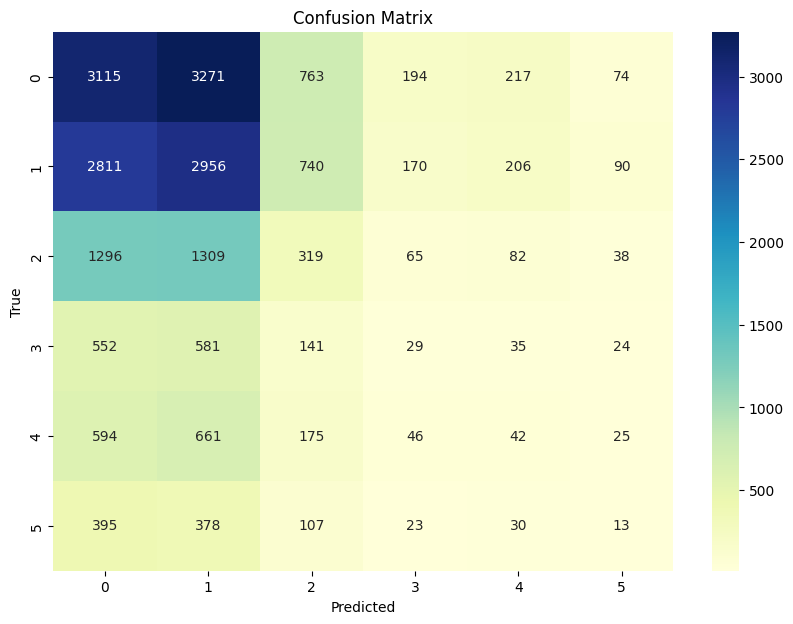

Precision (train):  0.26
Precision (test):  0.26
Recall (train):  0.3
Recall (test):  0.3
F1 Score (train):  0.28
F1 Score (test):  0.28


In [ ]:
# Calculate Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)

# Create confusion matrix
conf_matrixf = pd.DataFrame(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrixf, annot=True, fmt='d', cmap='YlGnBu')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Calculate Precision
precision_train = precision_score(y_train, y_pred_train, average='weighted')
precision_test = precision_score(y_test, y_pred_test, average='weighted')
print('Precision (train): ', round(precision_train, 2))
print('Precision (test): ', round(precision_test, 2))

# Calculate Recall
recall_train = recall_score(y_train, y_pred_train, average='weighted')
recall_test = recall_score(y_test, y_pred_test, average='weighted')
print('Recall (train): ', round(recall_train, 2))
print('Recall (test): ', round(recall_test, 2))

# Calculate F1 Score
f1_train = f1_score(y_train, y_pred_train, average='weighted')
f1_test = f1_score(y_test, y_pred_test, average='weighted')
print('F1 Score (train): ', round(f1_train, 2))
print('F1 Score (test): ', round(f1_test, 2))

In [ ]:
# Calculate Classification Report
classification_train = classification_report(y_test, y_pred_train)
classification_test = classification_report(y_test, y_pred_test)
print('Classification Report (train): ', classification_train)
print('Classification Report (test): ', classification_test)

#### Model 1: SGDClassifier

In [ ]:
# Instantiate and train SGDClassifier model
#model_1 = SGDClassifier(random_state=RSEED)
#model_1.fit(X_train, y_train)

##### RandomizedSearchCV

In [ ]:
# Define the parameter distribution for random search
param_dist = {
    'penalty': ['l2', 'l1', 'elasticnet', None],
    'alpha': loguniform(1e-2, 1e0),
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive']
}

# Create a base model
#base_estimator = DecisionTreeClassifier(random_state=RSEED)
SGD = SGDClassifier(random_state=RSEED)

# Create a custom scorer (you can change this to other metrics if needed)
scorer = make_scorer(f1_score)

# Instantiate RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=SGD,
    param_distributions=param_dist,
    n_iter=50,  # Reduced number of iterations
    cv=3,  # Reduced number of cross-validation folds
    scoring=scorer,
    random_state=RSEED,
    n_jobs=-1  # use all available cores
)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best parameters:", random_search.best_params_)
print("Best cross-validation score:", random_search.best_score_)

# Get the best model
model_1 = random_search.best_estimator_

In [ ]:
y_pred_train = model_1.predict(X_train)
y_pred_test = model_1.predict(X_test)

In [ ]:
# Save the model
dump(model_1, 'models/model_1.joblib')

In [ ]:
# Load model
model_1 = load('models/model_1.joblib')

##### Evaluation

In [ ]:
# Calculate Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)

# Create confusion matrix
conf_matrixf = pd.DataFrame(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrixf, annot=True, fmt='d', cmap='YlGnBu')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Calculate Precision
precision_train = precision_score(y_train, y_pred_train, average='weighted')
precision_test = precision_score(y_test, y_pred_test, average='weighted')
print('Precision (train): ', round(precision_train, 2))
print('Precision (test): ', round(precision_test, 2))

# Calculate Recall
recall_train = recall_score(y_train, y_pred_train, average='weighted')
recall_test = recall_score(y_test, y_pred_test, average='weighted')
print('Recall (train): ', round(recall_train, 2))
print('Recall (test): ', round(recall_test, 2))

# Calculate F1 Score
f1_train = f1_score(y_train, y_pred_train, average='weighted')
f1_test = f1_score(y_test, y_pred_test, average='weighted')
print('F1 Score (train): ', round(f1_train, 2))
print('F1 Score (test): ', round(f1_test, 2))

In [ ]:
# Calculate Classification Report
classification_train = classification_report(y_test, y_pred_train)
classification_test = classification_report(y_test, y_pred_test)
print('Classification Report (train): ', classification_train)
print('Classification Report (test): ', classification_test)

#### Model 2: KNeighborsClassifier

##### GridSearchCV

param_grid = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

Best parameters: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'uniform'}

In [54]:
# Instantiate and train KNeighborsClassifier
#model_2 = KNeighborsClassifier(**grid_search.best_params_) # Get best parameters from grid search
model_2 = KNeighborsClassifier(n_neighbors=7, weights='uniform', metric='manhattan')
model_2.fit(X_train, y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=7)

In [55]:
# Definition of hyperparameters
param_grid = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# GridSearchCV initiation
grid_search = GridSearchCV(model_2, param_grid, cv=5)

# Search for best parameters
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)

Best parameters: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'uniform'}


In [ ]:
y_pred_train = model_2.predict(X_train)
y_pred_test = model_2.predict(X_test)

In [ ]:
# Save the model
dump(model_2, 'models/model_2.joblib')

['models/model_2.joblib']

In [ ]:
# Load model
model_2 = load('models/model_2.joblib')

##### Evaluation

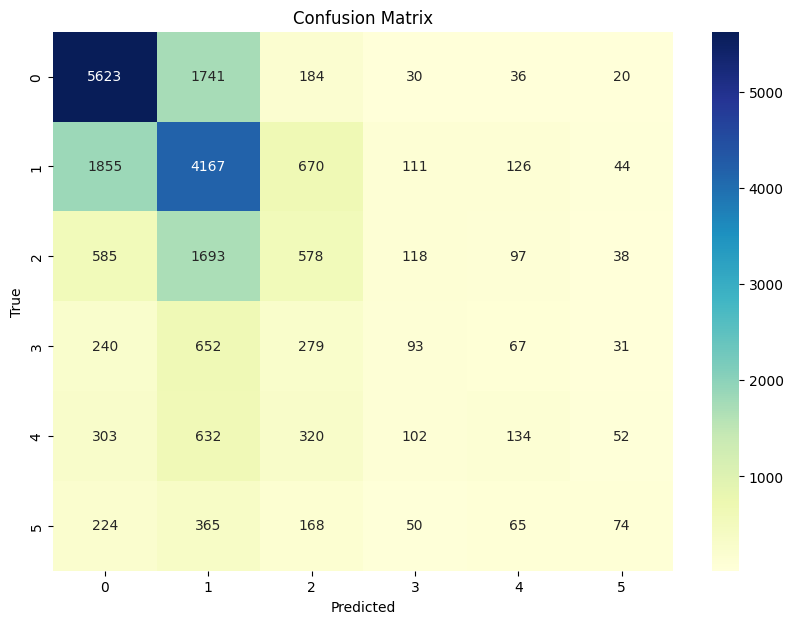

Precision (train):  0.58
Precision (test):  0.45
Recall (train):  0.6
Recall (test):  0.49
F1 Score (train):  0.57
F1 Score (test):  0.46


In [ ]:
# Calculate Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)

# Create confusion matrix
conf_matrixf = pd.DataFrame(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrixf, annot=True, fmt='d', cmap='YlGnBu')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Calculate Precision
precision_train = precision_score(y_train, y_pred_train, average='weighted')
precision_test = precision_score(y_test, y_pred_test, average='weighted')
print('Precision (train): ', round(precision_train, 2))
print('Precision (test): ', round(precision_test, 2))

# Calculate Recall
recall_train = recall_score(y_train, y_pred_train, average='weighted')
recall_test = recall_score(y_test, y_pred_test, average='weighted')
print('Recall (train): ', round(recall_train, 2))
print('Recall (test): ', round(recall_test, 2))

# Calculate F1 Score
f1_train = f1_score(y_train, y_pred_train, average='weighted')
f1_test = f1_score(y_test, y_pred_test, average='weighted')
print('F1 Score (train): ', round(f1_train, 2))
print('F1 Score (test): ', round(f1_test, 2))

In [ ]:
# Calculate Classification Report
classification_train = classification_report(y_test, y_pred_train)
classification_test = classification_report(y_test, y_pred_test)
print('Classification Report (train): ', classification_train)
print('Classification Report (test): ', classification_test)

#### Model 3: Decision Tree Classifier

In [ ]:
# Instantiate and train decision tree classifier on gini
#model_3 = DecisionTreeClassifier(criterion='gini', random_state=RSEED)
#model_3.fit(X_train, y_train)

##### RandomizedSearchCV

In [ ]:
# Define the parameter distribution for random search
param_dist = {
    'criterion': ['gini', 'entropy'],
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'max_features': uniform(0, 1)
}

# Create a base model
dt = DecisionTreeClassifier(random_state=RSEED)

# Create a custom scorer (you can change this to other metrics if needed)
scorer = make_scorer(accuracy_score)

# Instantiate RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=dt,
    param_distributions=param_dist,
    n_iter=100,  # number of parameter settings that are sampled
    cv=5,  # number of cross-validation folds
    scoring=scorer,
    random_state=RSEED,
    n_jobs=-1  # use all available cores
)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best parameters:", random_search.best_params_)
print("Best cross-validation score:", random_search.best_score_)

# Get the best model
model_3 = random_search.best_estimator_

In [ ]:
y_pred_train = model_3.predict(X_train)
y_pred_test = model_3.predict(X_test)

In [ ]:
# Save the model
dump(model_3, 'models/model_3.joblib')

In [ ]:
# Load model
model_3 = load('models/model_3.joblib')

##### Evaluation

In [ ]:
# Calculate Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)

# Create confusion matrix
conf_matrixf = pd.DataFrame(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrixf, annot=True, fmt='d', cmap='YlGnBu')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Calculate Precision
precision_train = precision_score(y_train, y_pred_train, average='weighted')
precision_test = precision_score(y_test, y_pred_test, average='weighted')
print('Precision (train): ', round(precision_train, 2))
print('Precision (test): ', round(precision_test, 2))

# Calculate Recall
recall_train = recall_score(y_train, y_pred_train, average='weighted')
recall_test = recall_score(y_test, y_pred_test, average='weighted')
print('Recall (train): ', round(recall_train, 2))
print('Recall (test): ', round(recall_test, 2))

# Calculate F1 Score
f1_train = f1_score(y_train, y_pred_train, average='weighted')
f1_test = f1_score(y_test, y_pred_test, average='weighted')
print('F1 Score (train): ', round(f1_train, 2))
print('F1 Score (test): ', round(f1_test, 2))

In [ ]:
# Calculate Classification Report
classification_train = classification_report(y_test, y_pred_train)
classification_test = classification_report(y_test, y_pred_test)
print('Classification Report (train): ', classification_train)
print('Classification Report (test): ', classification_test)

#### Model 4: Random Forest Classifier

In [ ]:
# Instantiate and train Random Forest Classifier model
#model_4 = RandomForestClassifier(random_state=RSEED, max_features = 'sqrt', n_jobs=-1, verbose = 1)
#model_4.fit(X_train, y_train)

##### GridSearchCV

In [ ]:
# Definition of hyperparameters
param_grid = {
    'n_estimators': [100, 200, 700],
    'max_depth': [10, 20, 30],
    'max_features': ['auto', 'sqrt', 'log2']
}

# GridSearchCV initiation
grid_search = GridSearchCV(model_4, param_grid, cv=5)

# Search for best parameters
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)

param_grid = {
    'n_estimators': [100, 200, 700],
    'max_depth': [10, 20, 30],
    'max_features': ['auto', 'sqrt', 'log2']
}

Best parameters: 

In [ ]:
# Instantiate and train Random Forest Classifier model
model_4 = RandomForestClassifier(random_state=RSEED, max_features = 'sqrt', n_jobs=-1, verbose = 1)
model_4.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    9.6s finished


RandomForestClassifier(n_jobs=-1, random_state=0, verbose=1)

In [ ]:
y_pred_train = model_4.predict(X_train)
y_pred_test = model_4.predict(X_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


In [ ]:
# Save the model
dump(model_4, 'models/model_4.joblib')

['models/model_4.joblib']

In [ ]:
# Load model
model_4 = load('models/model_4.joblib')

##### Evaluation

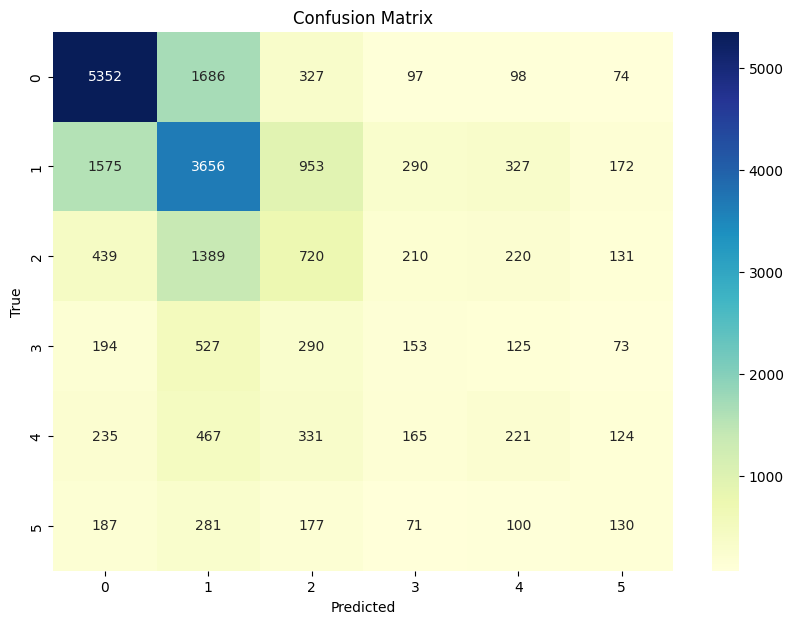

Precision (train):  0.8
Precision (test):  0.45
Recall (train):  0.8
Recall (test):  0.47
F1 Score (train):  0.8
F1 Score (test):  0.46


In [ ]:
# Calculate Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)

# Create confusion matrix
conf_matrixf = pd.DataFrame(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrixf, annot=True, fmt='d', cmap='YlGnBu')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Calculate Precision
precision_train = precision_score(y_train, y_pred_train, average='weighted')
precision_test = precision_score(y_test, y_pred_test, average='weighted')
print('Precision (train): ', round(precision_train, 2))
print('Precision (test): ', round(precision_test, 2))

# Calculate Recall
recall_train = recall_score(y_train, y_pred_train, average='weighted')
recall_test = recall_score(y_test, y_pred_test, average='weighted')
print('Recall (train): ', round(recall_train, 2))
print('Recall (test): ', round(recall_test, 2))

# Calculate F1 Score
f1_train = f1_score(y_train, y_pred_train, average='weighted')
f1_test = f1_score(y_test, y_pred_test, average='weighted')
print('F1 Score (train): ', round(f1_train, 2))
print('F1 Score (test): ', round(f1_test, 2))

In [ ]:
# Calculate Classification Report
classification_train = classification_report(y_test, y_pred_train)
classification_test = classification_report(y_test, y_pred_test)
print('Classification Report (train): ', classification_train)
print('Classification Report (test): ', classification_test)

Classification report of test data:

                precision    recall  f1-score   support

           1       0.67      0.70      0.69      7634
           2       0.46      0.52      0.49      6973
           3       0.26      0.23      0.24      3109
           4       0.16      0.11      0.13      1362
           5       0.20      0.14      0.17      1543
           6       0.18      0.14      0.16       946

    accuracy                           0.47     21567
   macro avg       0.32      0.31      0.31     21567
weighted avg       0.45      0.47      0.46     21567



#### Model 5: XGBClassifier

In [ ]:
# Instantiate and train XGBoost Classifier model
model_5 = XGBClassifier(random_state=RSEED)
model_5.fit(X_train, y_train - 1)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
y_pred_train = model_5.predict(X_train)
y_pred_test = model_5.predict(X_test)

In [ ]:
# Save the model
dump(model_5, 'models/model_5.joblib')

['models/model_5.joblib']

In [ ]:
# Load model
model_5 = load('models/model_5.joblib')

##### Evaluation

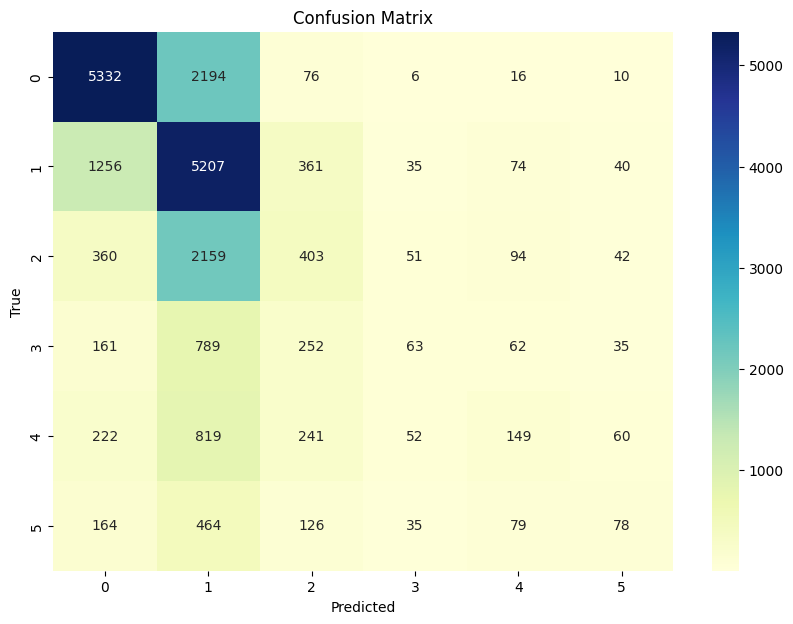

Precision (train):  0.56
Precision (test):  0.49
Recall (train):  0.56
Recall (test):  0.52
F1 Score (train):  0.52
F1 Score (test):  0.48


In [ ]:
# Calculate Confusion Matrix
conf_matrix = confusion_matrix(y_test - 1, y_pred_test)

# Create confusion matrix
conf_matrixf = pd.DataFrame(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrixf, annot=True, fmt='d', cmap='YlGnBu')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Calculate Precision
precision_train = precision_score(y_train - 1, y_pred_train, average='weighted')
precision_test = precision_score(y_test - 1, y_pred_test, average='weighted')
print('Precision (train): ', round(precision_train, 2))
print('Precision (test): ', round(precision_test, 2))

# Calculate Recall
recall_train = recall_score(y_train - 1, y_pred_train, average='weighted')
recall_test = recall_score(y_test - 1, y_pred_test, average='weighted')
print('Recall (train): ', round(recall_train, 2))
print('Recall (test): ', round(recall_test, 2))

# Calculate F1 Score
f1_train = f1_score(y_train - 1, y_pred_train, average='weighted')
f1_test = f1_score(y_test - 1, y_pred_test, average='weighted')
print('F1 Score (train): ', round(f1_train, 2))
print('F1 Score (test): ', round(f1_test, 2))

In [ ]:
# Calculate Classification Report
classification_train = classification_report(y_test, y_pred_train)
classification_test = classification_report(y_test, y_pred_test)
print('Classification Report (train): ', classification_train)
print('Classification Report (test): ', classification_test)

Classification report of test data:

                precision    recall  f1-score   support

           0       0.71      0.70      0.70      7634
           1       0.45      0.75      0.56      6973
           2       0.28      0.13      0.18      3109
           3       0.26      0.05      0.08      1362
           4       0.31      0.10      0.15      1543
           5       0.29      0.08      0.13       946

    accuracy                           0.52     21567
   macro avg       0.38      0.30      0.30     21567
weighted avg       0.49      0.52      0.48     21567



#### Model 6: Ada Boost

In [ ]:
# Instantiate and train Ada Boost classifier
#model_6 = AdaBoostClassifier(random_state=RSEED)
#model_6.fit(X_train, y_train)

##### RandomizedSearchCV

In [ ]:
# Define the parameter distribution for random search
param_dist = {
    'n_estimators': randint(50, 100),  # Reduced upper bound
    'learning_rate': uniform(0.01, 0.5),  # Reduced upper bound
    'base_estimator__max_depth': randint(1, 5),  # Reduced upper bound
    'base_estimator__min_samples_split': randint(2, 10),  # Reduced upper bound
    'base_estimator__min_samples_leaf': randint(1, 10),  # Reduced upper bound
    'algorithm': ['SAMME', 'SAMME.R']
}

# Create a base model
base_estimator = DecisionTreeClassifier(random_state=RSEED)
ada = AdaBoostClassifier(base_estimator=base_estimator, random_state=RSEED)

# Create a custom scorer (you can change this to other metrics if needed)
scorer = make_scorer(f1_score)

# Instantiate RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=ada,
    param_distributions=param_dist,
    n_iter=50,  # Reduced number of iterations
    cv=3,  # Reduced number of cross-validation folds
    scoring=scorer,
    random_state=RSEED,
    n_jobs=-1  # use all available cores
)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best parameters:", random_search.best_params_)
print("Best cross-validation score:", random_search.best_score_)

# Get the best model
model_6 = random_search.best_estimator_

In [ ]:
y_pred_train = model_6.predict(X_train)
y_pred_test = model_6.predict(X_test)

In [ ]:
# Save the model
dump(model_6, 'models/model_6.joblib')

In [ ]:
# Load model
model_6 = load('models/model_6.joblib')

##### Evaluation

In [ ]:
# Calculate Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)

# Create confusion matrix
conf_matrixf = pd.DataFrame(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrixf, annot=True, fmt='d', cmap='YlGnBu')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Calculate Precision
precision_train = precision_score(y_train, y_pred_train, average='weighted')
precision_test = precision_score(y_test, y_pred_test, average='weighted')
print('Precision (train): ', round(precision_train, 2))
print('Precision (test): ', round(precision_test, 2))

# Calculate Recall
recall_train = recall_score(y_train, y_pred_train, average='weighted')
recall_test = recall_score(y_test, y_pred_test, average='weighted')
print('Recall (train): ', round(recall_train, 2))
print('Recall (test): ', round(recall_test, 2))

# Calculate F1 Score
f1_train = f1_score(y_train, y_pred_train, average='weighted')
f1_test = f1_score(y_test, y_pred_test, average='weighted')
print('F1 Score (train): ', round(f1_train, 2))
print('F1 Score (test): ', round(f1_test, 2))

In [ ]:
# Calculate Classification Report
classification_train = classification_report(y_test, y_pred_train)
classification_test = classification_report(y_test, y_pred_test)
print('Classification Report (train): ', classification_train)
print('Classification Report (test): ', classification_test)

#### Model 7: Bagging

In [ ]:
# Instantiate and train Bagging Classifier with base model DecisionTreeClassifier
#model_7 = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=10, random_state=RSEED)
#model_7.fit(X_train, y_train)

##### RandomizedSearchCV

In [ ]:
# Define the parameter distribution for random search
param_dist = {
    'n_estimators': randint(10, 200),
    'max_samples': uniform(0.5, 1.0),
    'max_features': uniform(0.1, 1.0),  
    'bootstrap': [True, False],
    'bootstrap_features': [True, False],
    'base_estimator__max_depth': randint(1, 20),
    'base_estimator__min_samples_split': randint(2, 20),
    'base_estimator__min_samples_leaf': randint(1, 20)
}

# Create a base model
base_estimator = DecisionTreeClassifier(random_state=RSEED)
bagging = BaggingClassifier(base_estimator=base_estimator, random_state=RSEED)

# Create a custom scorer (you can change this to other metrics if needed)
scorer = make_scorer(f1_score, average='weighted')  # Specify average for multi-class

# Instantiate RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=bagging,
    param_distributions=param_dist,
    n_iter=100,  # number of parameter settings that are sampled
    cv=5,  # number of cross-validation folds
    scoring=scorer,
    random_state=RSEED,
    n_jobs=-1  # use all available cores
)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best parameters:", random_search.best_params_)
print("Best cross-validation score:", random_search.best_score_)

# Get the best model
model_7 = random_search.best_estimator_

In [ ]:
y_pred_train = model_7.predict(X_train)
y_pred_test = model_7.predict(X_test)

In [ ]:
# Save the model
dump(model_7, 'models/model_7.joblib')

In [ ]:
# Load model
model_7 = load('models/model_7.joblib')

##### Evaluation

In [ ]:
# Calculate Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)

# Create confusion matrix
conf_matrixf = pd.DataFrame(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrixf, annot=True, fmt='d', cmap='YlGnBu')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Calculate Precision
precision_train = precision_score(y_train, y_pred_train, average='weighted')
precision_test = precision_score(y_test, y_pred_test, average='weighted')
print('Precision (train): ', round(precision_train, 2))
print('Precision (test): ', round(precision_test, 2))

# Calculate Recall
recall_train = recall_score(y_train, y_pred_train, average='weighted')
recall_test = recall_score(y_test, y_pred_test, average='weighted')
print('Recall (train): ', round(recall_train, 2))
print('Recall (test): ', round(recall_test, 2))

# Calculate F1 Score
f1_train = f1_score(y_train, y_pred_train, average='weighted')
f1_test = f1_score(y_test, y_pred_test, average='weighted')
print('F1 Score (train): ', round(f1_train, 2))
print('F1 Score (test): ', round(f1_test, 2))

In [ ]:
# Calculate Classification Report
classification_train = classification_report(y_test, y_pred_train)
classification_test = classification_report(y_test, y_pred_test)
print('Classification Report (train): ', classification_train)
print('Classification Report (test): ', classification_test)

#### Model 8: Extra Trees

In [ ]:
# Instantiate and train extreme random tree regressor on poisson/squared_error/absolute_error/friedman_mse
#model_8 = ExtraTreesClassifier(random_state=RSEED, max_features='sqrt', n_jobs=-1, verbose=1, class_weight='balanced')
#model_8.fit(X_train, y_train)

##### RandomizedSearchCV

In [ ]:
# Define the parameter distribution for random search
param_dist = {
    #'class_weight': ['balanced', 'balanced_subsample'],  # takes count within classes into account 
    'max_depth': randint(50, 10000),
    'min_samples_leaf': randint(10, 100),
    #'min_samples_split': randint(2,10000),
    'n_estimators': randint(200, 5000),
    'criterion': ['gini', 'entropy', 'log_loss']
}

# Create a base model
XTC = ExtraTreesClassifier(random_state=RSEED, class_weight='balanced')

# Create a custom scorer (you can change this to other metrics if needed)
scorer = make_scorer(f1_score)

# Instantiate RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=XTC,
    param_distributions=param_dist,
    n_iter=50,  # Reduced number of iterations
    cv=3,  # Reduced number of cross-validation folds
    scoring=scorer,
    random_state=RSEED,
    n_jobs=-1  # use all available cores
)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best parameters:", random_search.best_params_)
print("Best cross-validation score:", random_search.best_score_)

# Get the best model
model_8_rscv = random_search.best_estimator_

##### GridSearchCV

In [ ]:
# Defining parameter grid
param_grid = {
    'max_feature': ['sqrt', 'log2', None],
    'min_samples_leaf': [10, 100, 200, 500, 1000, 10000],
    'n_estimators': [100, 500, 1000, 5000, 10000]
}
    
# Create a base model
XTC = ExtraTreesClassifier(random_state=RSEED) #, class_weight='balanced')
    
# Create a custom scorer (you can change this to other metrics if needed)
scorer = make_scorer(f1_score)
    
# Instantiate gridsearch and define the metric to optimize 
grid_search = GridSearchCV(
    estimator=XTC, 
    param_grid=param_grid,
    scoring=scorer,
    cv=3,  # Reduced number of cross-validation folds 
    verbose=5, 
    n_jobs=-1 # use all available cores
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Get the best model
model_8_gscv = grid_search.best_estimator_

In [ ]:
y_pred_train = model_8_gscv.predict(X_train)
y_pred_test = model_8_gscv.predict(X_test)

In [ ]:
# Save the model
dump(model_8_gscv, 'models/model_8.joblib')

In [ ]:
# Load model
model_8_gscv = load('models/model_8.joblib')

##### Evaluation

In [ ]:
# Calculate Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)

# Create confusion matrix
conf_matrixf = pd.DataFrame(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrixf, annot=True, fmt='d', cmap='YlGnBu')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Calculate Precision
precision_train = precision_score(y_train, y_pred_train, average='weighted')
precision_test = precision_score(y_test, y_pred_test, average='weighted')
print('Precision (train): ', round(precision_train, 2))
print('Precision (test): ', round(precision_test, 2))

# Calculate Recall
recall_train = recall_score(y_train, y_pred_train, average='weighted')
recall_test = recall_score(y_test, y_pred_test, average='weighted')
print('Recall (train): ', round(recall_train, 2))
print('Recall (test): ', round(recall_test, 2))

# Calculate F1 Score
f1_train = f1_score(y_train, y_pred_train, average='weighted')
f1_test = f1_score(y_test, y_pred_test, average='weighted')
print('F1 Score (train): ', round(f1_train, 2))
print('F1 Score (test): ', round(f1_test, 2))

In [ ]:
# Calculate Classification Report
classification_train = classification_report(y_test, y_pred_train)
classification_test = classification_report(y_test, y_pred_test)
print('Classification Report (train): ', classification_train)
print('Classification Report (test): ', classification_test)

#### Model 9: Gradient Boosting Classifier

In [ ]:
# Instantiate and train Gradient Boosting Classifier
#model_9 = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, min_samples_split=2, min_samples_leaf=1, subsample=1.0, max_features='sqrt', random_state=RSEED)
#model_9.fit(X_train, y_train)

##### RandomizedSearchCV¶

In [ ]:
# Define the parameter distribution for random search
param_dist = {
    'n_estimators': randint(100, 10000),
    'learning_rate': uniform(0.05, 1),
    'loss': ['log_loss', 'exponential']
    
    'class_weight': ['balanced', 'balanced_subsample'],  # takes count within classes into account 
    'max_depth': randint(10, 10000),
    'min_samples_leaf': randint(10, 50000),
    #'min_samples_split': randint(2,10000),
    'n_estimators': randint(100, 10000),
    'criterion': ['gini', 'entropy', 'log_loss']
}

# Create a base model
#base_estimator = DecisionTreeClassifier(random_state=RSEED)
GBC = ExtraTreesClassifier(random_state=RSEED)

# Create a custom scorer (you can change this to other metrics if needed)
scorer = make_scorer(f1_score)

# Instantiate RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=GBC,
    param_distributions=param_dist,
    n_iter=50,  # Reduced number of iterations
    cv=3,  # Reduced number of cross-validation folds
    scoring=scorer,
    random_state=RSEED,
    n_jobs=-1  # use all available cores
)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best parameters:", random_search.best_params_)
print("Best cross-validation score:", random_search.best_score_)

# Get the best model
model_9 = random_search.best_estimator_

In [ ]:
y_pred_train = model_9.predict(X_train)
y_pred_test = model_9.predict(X_test)

In [ ]:
# Save the model
dump(model_9, 'models/model_9.joblib')

In [ ]:
# Load model
model_9 = load('models/model_9.joblib')

##### Evaluation

In [ ]:
# Calculate Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)

# Create confusion matrix
conf_matrixf = pd.DataFrame(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrixf, annot=True, fmt='d', cmap='YlGnBu')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Calculate Precision
precision_train = precision_score(y_train, y_pred_train, average='weighted')
precision_test = precision_score(y_test, y_pred_test, average='weighted')
print('Precision (train): ', round(precision_train, 2))
print('Precision (test): ', round(precision_test, 2))

# Calculate Recall
recall_train = recall_score(y_train, y_pred_train, average='weighted')
recall_test = recall_score(y_test, y_pred_test, average='weighted')
print('Recall (train): ', round(recall_train, 2))
print('Recall (test): ', round(recall_test, 2))

# Calculate F1 Score
f1_train = f1_score(y_train, y_pred_train, average='weighted')
f1_test = f1_score(y_test, y_pred_test, average='weighted')
print('F1 Score (train): ', round(f1_train, 2))
print('F1 Score (test): ', round(f1_test, 2))

In [ ]:
# Calculate Classification Report
classification_train = classification_report(y_test, y_pred_train)
classification_test = classification_report(y_test, y_pred_test)
print('Classification Report (train): ', classification_train)
print('Classification Report (test): ', classification_test)

#### Model 10: Stacking

In [ ]:
# Hyperparameter grid
estimators = [
    ('dt', model_3),
    ('ada', model_6),
    ('bag', model_7)
    ]

model1 = model_3
model2 = model_6
model3 = model_7

# Instantiate and train Stacking Classifier/Regressor model
model_10 = StackingClassifier(estimators=estimators, final_estimator=DecisionTreeClassifier(), cv=5, stack_method='predict_proba')
model_10.fit(X_train, y_train).score(X_test, y_test)

In [ ]:
# Save the model
dump(model_10, 'models/model_10.joblib')

In [ ]:
# Load model
model_10 = load('models/model_10.joblib')

##### Evaluation

In [ ]:
# Calculate Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)

# Create confusion matrix
conf_matrixf = pd.DataFrame(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrixf, annot=True, fmt='d', cmap='YlGnBu')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Calculate Precision
precision_train = precision_score(y_train, y_pred_train, average='weighted')
precision_test = precision_score(y_test, y_pred_test, average='weighted')
print('Precision (train): ', round(precision_train, 2))
print('Precision (test): ', round(precision_test, 2))

# Calculate Recall
recall_train = recall_score(y_train, y_pred_train, average='weighted')
recall_test = recall_score(y_test, y_pred_test, average='weighted')
print('Recall (train): ', round(recall_train, 2))
print('Recall (test): ', round(recall_test, 2))

# Calculate F1 Score
f1_train = f1_score(y_train, y_pred_train, average='weighted')
f1_test = f1_score(y_test, y_pred_test, average='weighted')
print('F1 Score (train): ', round(f1_train, 2))
print('F1 Score (test): ', round(f1_test, 2))

In [ ]:
# Calculate Classification Report
classification_train = classification_report(y_test, y_pred_train)
classification_test = classification_report(y_test, y_pred_test)
print('Classification Report (train): ', classification_train)
print('Classification Report (test): ', classification_test)

#### Model 11: Max Voting Classifier

In [ ]:
# Instantiate models
model1 = model_3 # Decision Tree
model2 = model_6 # Ada Boost
model3 = model_7 # Bagging

# Instantiate and train Voting Classifier model
model_11 = VotingClassifier(estimators=[('dt', model1), ('ada', model2), ('bag', model3)], voting='soft')
model_11.fit(X_train, y_train)

In [ ]:
y_pred_train = model_11.predict(X_train)
y_pred_test = model_11.predict(X_test)

In [ ]:
# Save the model
dump(model_11, 'models/model_11.joblib')

In [ ]:
# Load model
model_11 = load('models/model_11.joblib')

##### Evaluation

In [ ]:
# Calculate Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)

# Create confusion matrix
conf_matrixf = pd.DataFrame(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrixf, annot=True, fmt='d', cmap='YlGnBu')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Calculate Precision
precision_train = precision_score(y_train, y_pred_train, average='weighted')
precision_test = precision_score(y_test, y_pred_test, average='weighted')
print('Precision (train): ', round(precision_train, 2))
print('Precision (test): ', round(precision_test, 2))

# Calculate Recall
recall_train = recall_score(y_train, y_pred_train, average='weighted')
recall_test = recall_score(y_test, y_pred_test, average='weighted')
print('Recall (train): ', round(recall_train, 2))
print('Recall (test): ', round(recall_test, 2))

# Calculate F1 Score
f1_train = f1_score(y_train, y_pred_train, average='weighted')
f1_test = f1_score(y_test, y_pred_test, average='weighted')
print('F1 Score (train): ', round(f1_train, 2))
print('F1 Score (test): ', round(f1_test, 2))

In [ ]:
# Calculate Classification Report
classification_train = classification_report(y_test, y_pred_train)
classification_test = classification_report(y_test, y_pred_test)
print('Classification Report (train): ', classification_train)
print('Classification Report (test): ', classification_test)

## Evaluation

## Validation

## Packaging